In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings("ignore")

In [96]:
df = pd.read_csv("../Data_Preparation/data.tsv", sep="\t")

print("Dataset loaded:")
print(df.head())

Dataset loaded:
  EntryID               OrganismName        Kingdom  SequenceLength  SPStart  \
0  Q16552               Homo sapiens        Metazoa             155      1.0   
1  Q9M373       Arabidopsis thaliana  Viridiplantae              74      1.0   
2  P62520  Chilobrachys guangxiensis        Metazoa              63      1.0   
3  Q8I7X1           Porcellio scaber        Metazoa             145      1.0   
4  P14625               Homo sapiens        Metazoa             803      1.0   

   SPEnd     Label HelixDomain  \
0   23.0  Positive         NaN   
1   26.0  Positive         NaN   
2   27.0  Positive         NaN   
3   21.0  Positive         NaN   
4   21.0  Positive         NaN   

                                            Sequence  Set  
0  MTPGKTSLVSLLLLLSLEAIVKAGITIPRNPGCPNSEDKNFPRTVM...  4.0  
1  MASRNSVAVIALFAFVFAVISPFAGAQSLAPAPSPTSDGTSIDQGI...  1.0  
2  MKNTSILFILGLALLLVLAFEAQVGESDGECGGFWWKCGRGKPPCC...  2.0  
3  MKGLLFIVSLLCLTLHQRVWAYQVIGMKSDVICADIRFTVHCICNE...  4.0 

In [97]:
# SwissProt amino acid frequencies (https://web.expasy.org/docs/relnotes/relstat.html)
swissprot_freq = {
    'A': 0.08, 'R': 0.06, 'N': 0.04, 'D': 0.06, 'C': 0.01,
    'Q': 0.04, 'E': 0.07, 'G': 0.07, 'H': 0.02, 'I': 0.06,
    'L': 0.10, 'K': 0.06, 'M': 0.02, 'F': 0.04, 'P': 0.05,
    'S': 0.07, 'T': 0.05, 'W': 0.01, 'Y': 0.03, 'V': 0.07
}

In [98]:
def extract_cleavage_context(sequence, sp_end, window_size=15):
    """
    Extracts the 15 subsequence around the cleavage site with SPStart and SPEnd information.
    -13 to +2 (including 2 amino acids after cleavage)
    """
    cleavage_pos = int(sp_end)
    start_pos = cleavage_pos - 13
    end_pos = cleavage_pos + 2

    if start_pos < 0 or end_pos > len(sequence):
        return None

    context = sequence[start_pos:end_pos]
    if len(context) != window_size:
        return None

    return context

In [99]:
def build_pswm_heatmap(sequences, window_size=15, pseudocount=1):
    aa_list = list(swissprot_freq.keys())
    aa_to_idx = {aa: i for i, aa in enumerate(aa_list)}

    # Initialize the count matrix (with pseudocount)
    count_matrix = np.ones((len(aa_list), window_size))  # 20x15

    # Update count for each array
    for seq in sequences:
        if len(seq) != window_size:
            continue
        for j, aa in enumerate(seq):
            if aa in aa_to_idx:
                count_matrix[aa_to_idx[aa], j] += 1

    # Calculate PSPM
    N = len(sequences)
    pspm = count_matrix / (N + 20)

    # Calculate PSWM (log-odds)
    pswm = np.zeros_like(pspm)
    for i, aa in enumerate(aa_list):
        pswm[i, :] = np.log2(pspm[i, :] / swissprot_freq[aa])

    return pswm, aa_list

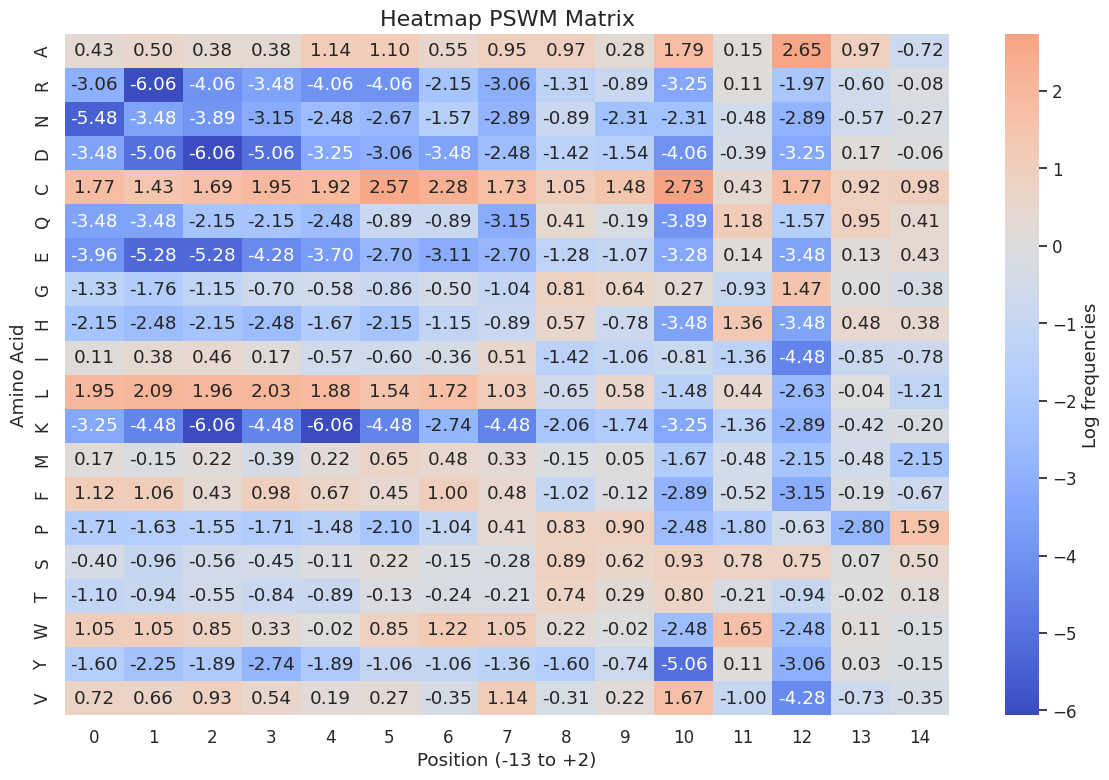

In [100]:
# Extract cleavage contexts from positive samples
positive_sequences = df[df['Label'] == 'Positive']

cleavage_contexts = []
for _, row in positive_sequences.iterrows():
    seq = row['Sequence']
    sp_end = row['SPEnd']
    context = extract_cleavage_context(seq,sp_end)
    if context:
        cleavage_contexts.append(context)


# PSWM
pswm, aa_list = build_pswm_heatmap(cleavage_contexts)

# Heatmap
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.1)
ax = sns.heatmap(pswm,
                 annot=True,
                 fmt=".2f",
                 cmap="coolwarm",
                 center=0,
                 xticklabels=[f"{i}" for i in range(15)],
                 yticklabels=aa_list,
                 cbar_kws={'label': 'Log frequencies'})

plt.title('Heatmap PSWM Matrix', fontsize=16)
plt.xlabel('Position (-13 to +2)')
plt.ylabel('Amino Acid')
plt.tight_layout()
plt.show()

In [101]:
aa_list = list(swissprot_freq.keys())
aa_to_idx = {aa: i for i, aa in enumerate(aa_list)}

def score_protein_sequence(seq, pswm, aa_to_idx, window_size=15, n_terminal=90):
    # Consider only the first `n_terminal` residues
    seq = seq[:n_terminal]

    # If sequence is shorter than the window, return a very low score
    if len(seq) < window_size:
        return -1000.0

    max_score = -np.inf

    # Slide window from position 0 to len(seq) - window_size
    for i in range(len(seq) - window_size + 1):
        subseq = seq[i:i + window_size]

        score = 0.0
        valid = True

        # Score each amino acid in the window
        for j, aa in enumerate(subseq):
            if aa not in aa_to_idx:
                valid = False
                break
            score += pswm[aa_to_idx[aa], j]

        if valid and score > max_score:
            max_score = score

    # Return a finite fallback if no valid window was found
    return max_score if max_score != -np.inf else -1000.0

In [102]:
df['vonHeijne_Score'] = df['Sequence'].apply(
    lambda x: score_protein_sequence(x, pswm, aa_to_idx)
)

print("Scoring completed!")
print(df[['EntryID', 'Label', 'vonHeijne_Score']].head())

Scoring completed!
  EntryID     Label  vonHeijne_Score
0  Q16552  Positive        11.248437
1  Q9M373  Positive         9.833584
2  P62520  Positive        12.967732
3  Q8I7X1  Positive        14.098521
4  P14625  Positive        15.230660


In [103]:
from sklearn.model_selection import StratifiedKFold

# Recreate the 'Set' column if missing or invalid
if 'Set' not in df.columns or set(df['Set'].unique()) != {0, 1, 2, 3, 4}:
    print("🔄 'Set' column is missing or invalid. Recreating it with stratified 5-fold split...")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    df['Set'] = -1
    for fold, (_, test_idx) in enumerate(skf.split(df, df['Label'])):
        df.loc[test_idx, 'Set'] = fold
    print("✅ New 'Set' column created successfully.")
    print(df['Set'].value_counts().sort_index())

🔄 'Set' column is missing or invalid. Recreating it with stratified 5-fold split...
✅ New 'Set' column created successfully.
Set
0    2006
1    2006
2    2005
3    2005
4    2005
Name: count, dtype: int64



=== FOLD 1 ===
Train: 6015, Validation: 2006, Test: 2006


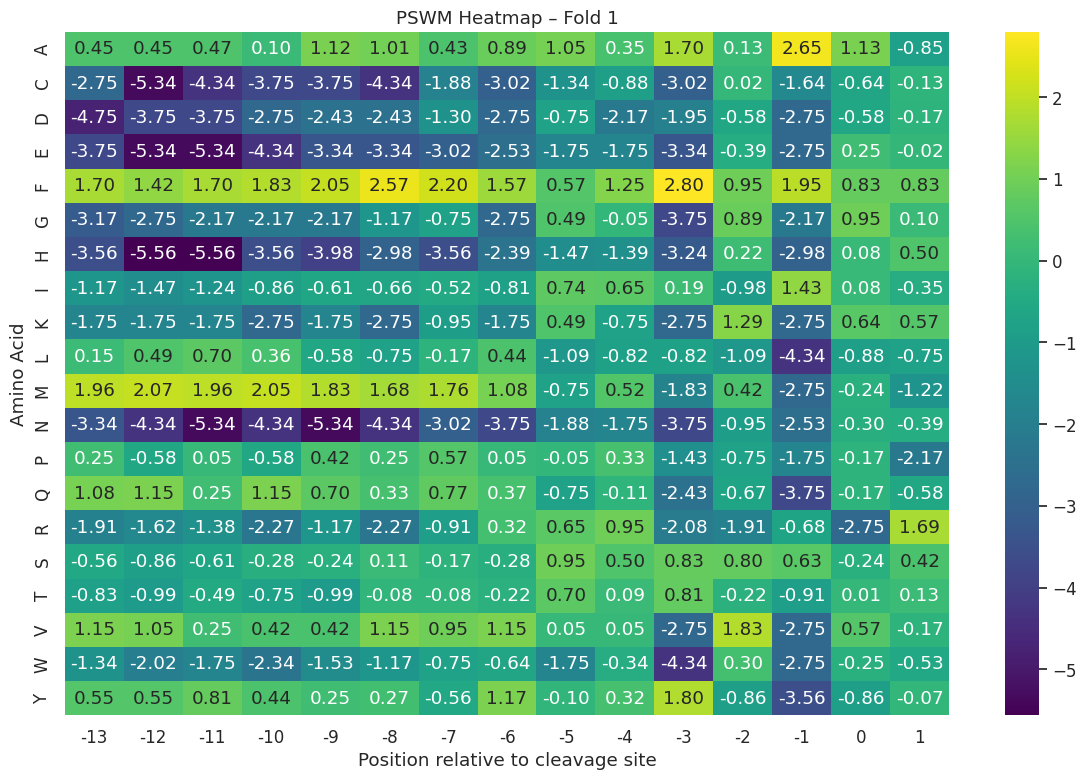

Optimal threshold: 8.7808


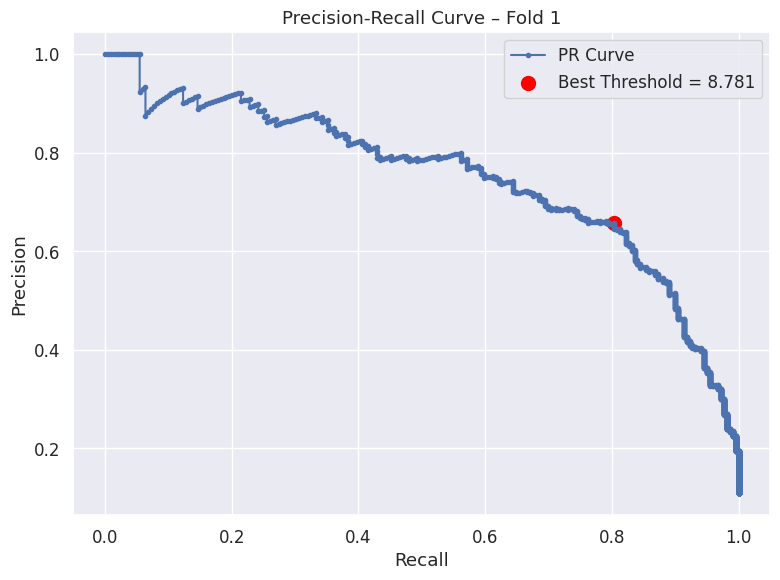

MCC: 0.674672
Precision: 0.669355
Accuracy: 0.932702
Sensitivity (Recall): 0.757991
Confusion Matrix:
[[1705   82]
 [  53  166]]

=== FOLD 2 ===
Train: 6016, Validation: 2005, Test: 2006


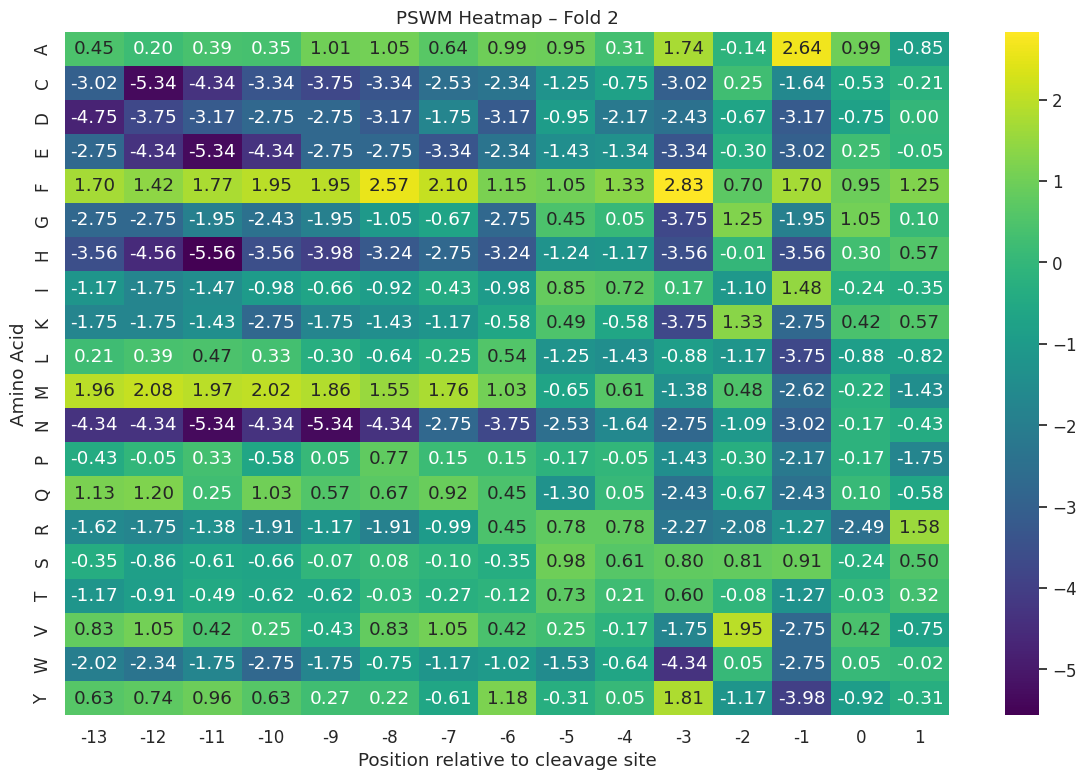

Optimal threshold: 9.1094


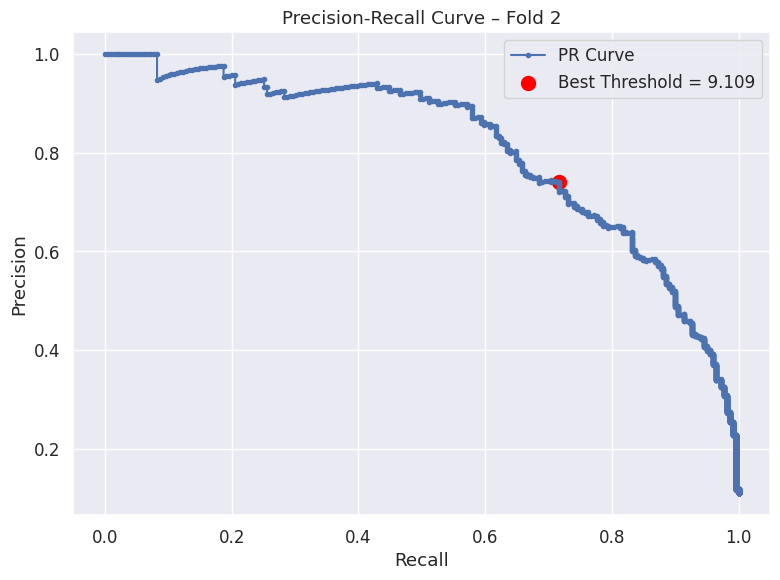

MCC: 0.675221
Precision: 0.677686
Accuracy: 0.933699
Sensitivity (Recall): 0.748858
Confusion Matrix:
[[1709   78]
 [  55  164]]

=== FOLD 3 ===
Train: 6017, Validation: 2005, Test: 2005


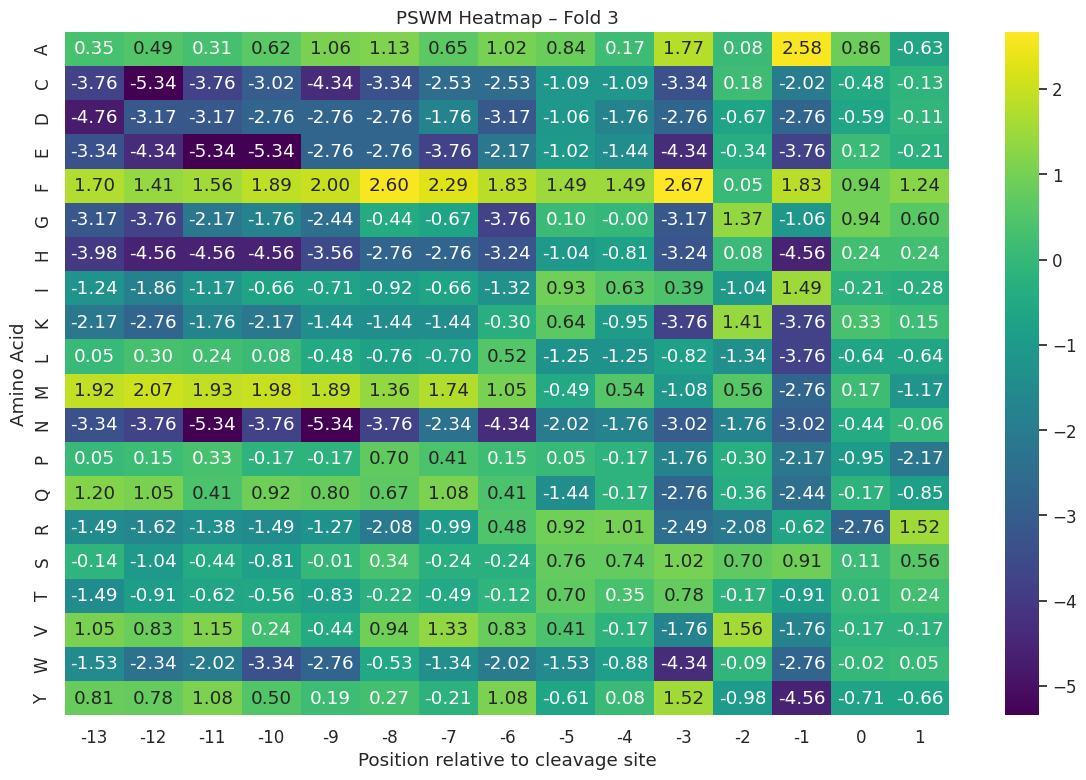

Optimal threshold: 9.9277


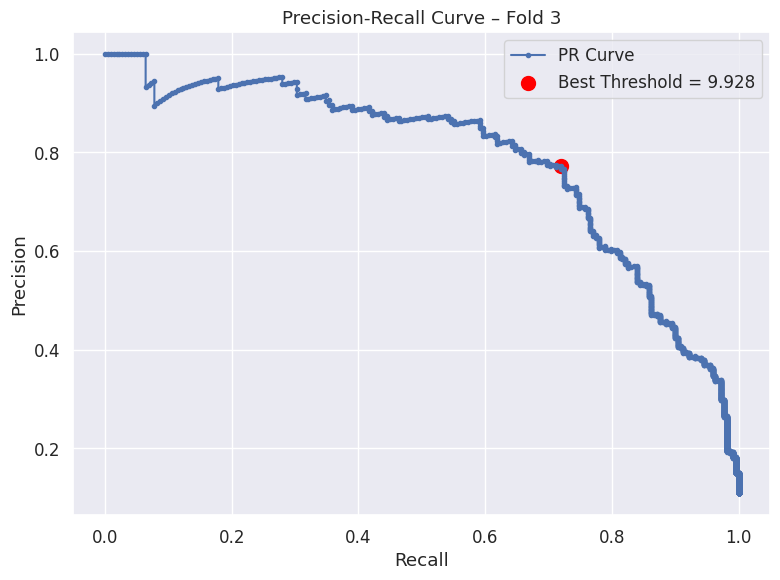

MCC: 0.672841
Precision: 0.757895
Accuracy: 0.939651
Sensitivity (Recall): 0.657534
Confusion Matrix:
[[1740   46]
 [  75  144]]

=== FOLD 4 ===
Train: 6017, Validation: 2005, Test: 2005


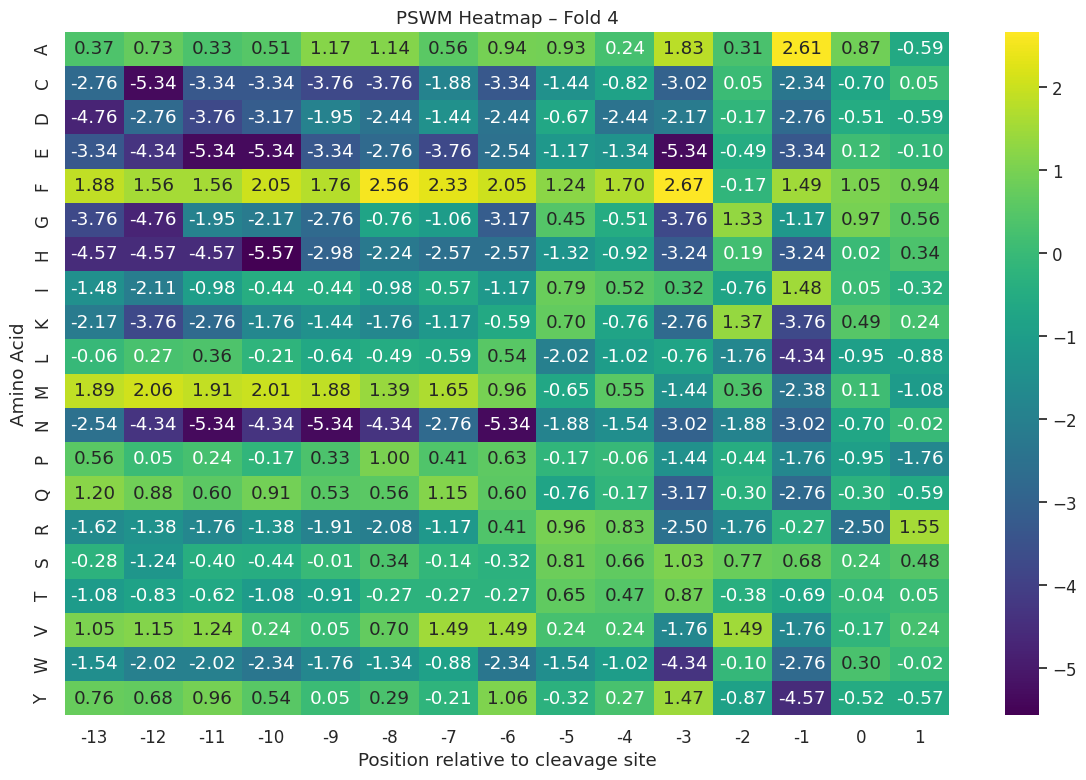

Optimal threshold: 8.5230


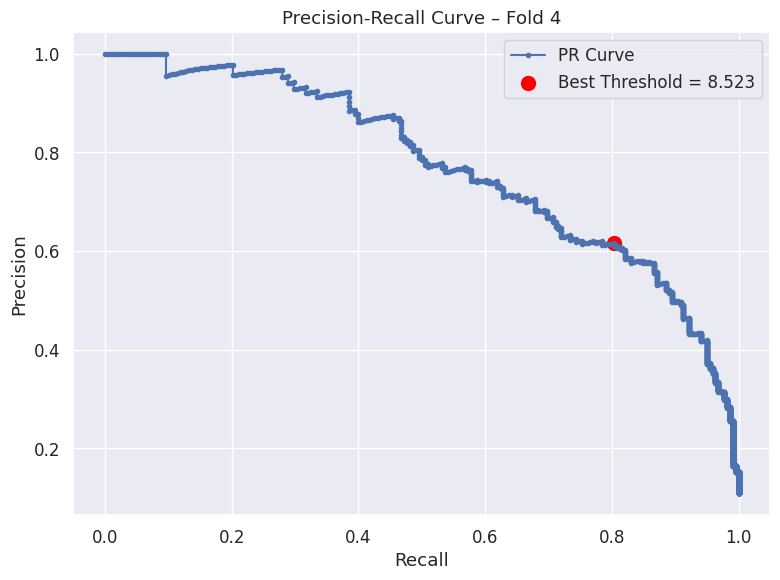

MCC: 0.649079
Precision: 0.623134
Accuracy: 0.924190
Sensitivity (Recall): 0.766055
Confusion Matrix:
[[1686  101]
 [  51  167]]

=== FOLD 5 ===
Train: 6016, Validation: 2006, Test: 2005


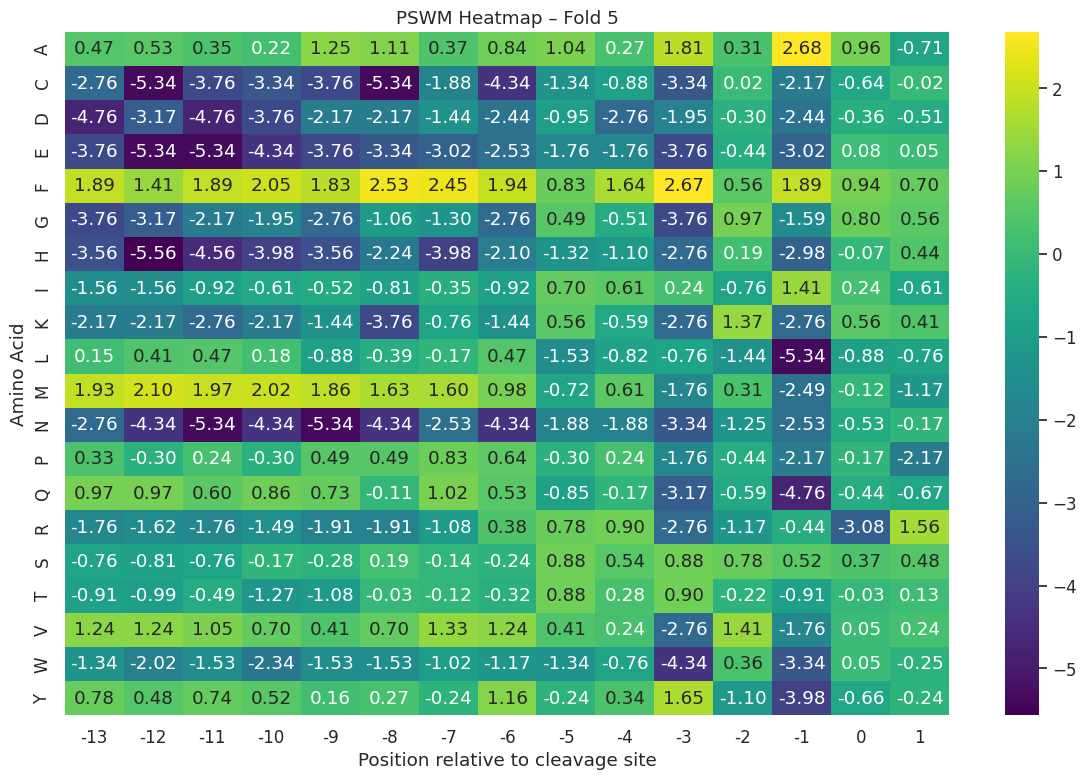

Optimal threshold: 8.4965


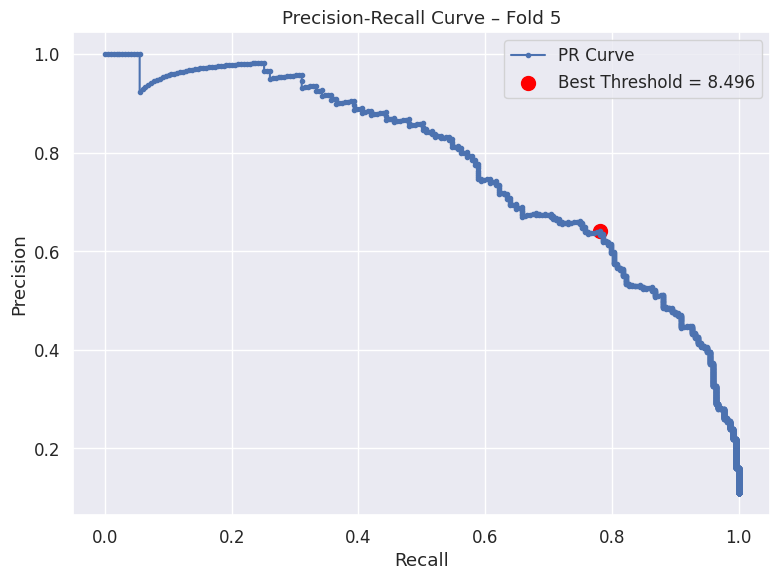

MCC: 0.660417
Precision: 0.620072
Accuracy: 0.924688
Sensitivity (Recall): 0.793578
Confusion Matrix:
[[1681  106]
 [  45  173]]

✅ AVERAGE METRICS (5-FOLD CROSS-VALIDATION)
MCC: 0.666446 ± 0.011440
Precision: 0.669628 ± 0.055842
Accuracy: 0.930986 ± 0.006543
Sensitivity: 0.744803 ± 0.051568

Average Confusion Matrix:
[[1704   82]
 [  55  162]]


In [104]:
from sklearn.metrics import (
    matthews_corrcoef,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert labels to binary format
df['True_Label'] = df['Label'].map({'Positive': 1, 'Negative': 0})

# Store results for each fold
all_results = []
all_conf_matrices = []

# 5-fold cross-validation loop
for fold in range(5):
    print(f"\n=== FOLD {fold + 1} ===")

    # Test set: where 'Set' == fold
    test_df = df[df['Set'] == fold].copy()
    if len(test_df) == 0:
        print("Warning: Test set is empty. Skipping fold.")
        continue

    # Validation set: next fold (circular)
    val_fold = (fold + 1) % 5
    val_df = df[df['Set'] == val_fold].copy()
    if len(val_df) == 0:
        print("Warning: Validation set is empty. Skipping fold.")
        continue

    # Training set: all other folds
    train_df = df[(df['Set'] != fold) & (df['Set'] != val_fold)].copy()
    if len(train_df) == 0:
        print("Warning: Training set is empty. Skipping fold.")
        continue

    print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

    # 1. Build PSWM from positive training examples
    pos_train = train_df[train_df['Label'] == 'Positive']
    cleavage_contexts = []
    for _, row in pos_train.iterrows():
        seq = row['Sequence']
        sp_end = row['SPEnd']
        ctx = extract_cleavage_context(seq, sp_end)
        if ctx:
            cleavage_contexts.append(ctx)

    if len(cleavage_contexts) == 0:
        print("Warning: No positive examples found. Skipping fold.")
        continue

    pswm_fold, _ = build_pswm_heatmap(cleavage_contexts)

    # === Plot PSWM Heatmap ===
    plt.figure(figsize=(12, 8))
    amino_acids = sorted(aa_to_idx.keys())
    positions = list(range(-13, 2))
    sns.heatmap(
        pswm_fold,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        xticklabels=positions,
        yticklabels=amino_acids
    )
    plt.title(f"PSWM Heatmap – Fold {fold + 1}")
    plt.xlabel("Position relative to cleavage site")
    plt.ylabel("Amino Acid")
    plt.tight_layout()
    plt.show()


    # 2. Score validation set and select optimal threshold
    val_df['Val_Score'] = val_df['Sequence'].apply(
        lambda x: score_protein_sequence(x, pswm_fold, aa_to_idx)
    )

    y_val_true = val_df['True_Label'].values
    y_val_scores = val_df['Val_Score'].values

    # Compute Precision-Recall curve
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_val_true, y_val_scores)

    # Compute F1-score for each threshold
    fscore = (2 * precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    best_idx = np.argmax(fscore)

    # Handle edge case: thresholds has one fewer element than precision/recall
    if best_idx < len(thresholds):
        optimal_threshold = thresholds[best_idx]
    else:
        optimal_threshold = thresholds[-1]

    print(f"Optimal threshold: {optimal_threshold:.4f}")

    # === Plot Precision-Recall Curve ===
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, marker='.', label='PR Curve')
    plt.scatter(
        recall_vals[best_idx],
        precision_vals[best_idx],
        color='red',
        s=100,
        label=f'Best Threshold = {optimal_threshold:.3f}'
    )
    plt.title(f'Precision-Recall Curve – Fold {fold + 1}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Score test set and make predictions
    test_df['Test_Score'] = test_df['Sequence'].apply(
        lambda x: score_protein_sequence(x, pswm_fold, aa_to_idx)
    )
    y_test_true = test_df['True_Label'].values
    y_test_pred = (test_df['Test_Score'] >= optimal_threshold).astype(int)

    # 4. Compute evaluation metrics
    mcc = matthews_corrcoef(y_test_true, y_test_pred)
    precision = precision_score(y_test_true, y_test_pred, zero_division=0)
    accuracy = accuracy_score(y_test_true, y_test_pred)
    sensitivity = recall_score(y_test_true, y_test_pred, zero_division=0)
    cm = confusion_matrix(y_test_true, y_test_pred)

    # Store results
    all_results.append({
        'Fold': fold + 1,
        'MCC': mcc,
        'Precision': precision,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Threshold': optimal_threshold
    })
    all_conf_matrices.append(cm)

    # 5. Print fold results
    print(f"MCC: {mcc:.6f}")
    print(f"Precision: {precision:.6f}")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Sensitivity (Recall): {sensitivity:.6f}")
    print("Confusion Matrix:")
    print(cm)

# Compute average metrics across folds
if all_results:
    avg_df = pd.DataFrame(all_results)
    print("\n" + "="*50)
    print("✅ AVERAGE METRICS (5-FOLD CROSS-VALIDATION)")
    print("="*50)
    for col in ['MCC', 'Precision', 'Accuracy', 'Sensitivity']:
        mean_val = avg_df[col].mean()
        std_val = avg_df[col].std()
        print(f"{col}: {mean_val:.6f} ± {std_val:.6f}")

    # Average confusion matrix
    avg_cm = np.mean(all_conf_matrices, axis=0).astype(int)
    print("\nAverage Confusion Matrix:")
    print(avg_cm)
else:
    print("No folds were processed. Ensure the 'Set' column contains values 0–4.")